#### Import Dependencies

In [72]:
import os
import time
import json
from datetime import datetime
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, from_json, udf, size, array_sort, split, when, lit, explode,
    regexp_replace, expr, mean, sum as _sum, count, concat_ws, to_date, monotonically_increasing_id, year
)
from pyspark.sql.types import *

#### Fetch Movies Data 

In [ ]:
def fetch_movie_data_spark(movie_ids, save_path="data/raw"):
    # Load env variables
    load_dotenv()
    api_key = os.getenv('API_KEY')
    base_url = os.getenv('BASE_url') 

    # Initialize Spark
    spark = SparkSession.builder.appName("FetchTMDBMovies").getOrCreate()

    movies_data = []
    for movie_id in movie_ids:
        for attempt in range(3):
            try:
                url = f'{base_url}{movie_id}?api_key={api_key}&append_to_response=credits'
                r = requests.get(url)
                if r.status_code == 200:
                    movies_data.append(r.json())
                    break
                elif r.status_code == 429:
                    print("Rate limit hit. Waiting 3 seconds...")
                    time.sleep(3)
                else:
                    print(f"Failed: {movie_id} (Status {r.status_code})")
                    time.sleep(1)
            except Exception as e:
                print(f"Error: {e}")
                time.sleep(1)

        time.sleep(0.3)  # ~3 req/sec max

    # Convert to RDD and DataFrame
    rdd = spark.sparkContext.parallelize([json.dumps(movie) for movie in movies_data])
    df = spark.read.json(rdd)


    # Save using timestamp
    timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    full_path = f"{save_path}/moviesData_{timestamp}.parquet"
    df.coalesce(1).write.mode("overwrite").parquet(full_path)

    print(f"Data saved to {full_path}")

    return df


In [ ]:
#Function call for data extraxtions
movie_ids = [
    0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428,
    168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445,
    321612, 260513
]

df = fetch_movie_data_spark(movie_ids)

#df.show(3, truncate=False)

#### Data Cleaning

In [48]:
# Spark session
spark = SparkSession.builder.appName("TMDBCleaning").getOrCreate()

def dataCleaning(df):
    # Drop unnecessary columns
    drop_cols = ["adult", "imdb_id", "original_title", "video", "homepage"]
    df = df.drop(*drop_cols)

    # Parse nested JSON fields
    #genre
    df = df.withColumn("genres", concat_ws("|", expr("transform(genres, x -> x.name)")))

    #belongs_to_collection
    df = df.withColumn("belongs_to_collection", col("belongs_to_collection.name"))

    #production_countries
    df = df.withColumn("production_countries", expr("array_join(transform(production_countries, x -> x.name), '|')"))

    #production_companies
    df = df.withColumn("production_companies", expr("array_join(transform(production_companies, x -> x.name), '|')"))

    #spoken_languages
    df = df.withColumn("spoken_languages", expr("array_join(transform(spoken_languages, x -> x.english_name), '|')"))

    # Extract cast, director, cast size, and crew size from credits
    # Extract relevant info
    df = df.withColumn("cast", expr("array_join(transform(credits.cast, x -> x.name), '|')"))
    df = df.withColumn("cast_size", size("credits.cast"))
    df = df.withColumn("crew_size", size("credits.crew"))

    # Safely extract director — check for empty array
    df = df.withColumn("director", expr("""
        CASE 
            WHEN size(filter(credits.crew, x -> x.job = 'Director')) > 0 
            THEN filter(credits.crew, x -> x.job = 'Director')[0].name 
            ELSE NULL 
        END
    """))

    # Drop the original credits field
    df = df.drop("credits")

    # Clean up multiple-value columns (sorted order)
    for col_name in ["genres", "production_countries", "spoken_languages"]:
        df = df.withColumn(
            col_name,
            expr(f"array_join(array_sort(transform(split({col_name}, '\\\\|'), x -> trim(x))), '|')")
        )

    # Convert numeric fields
    num_cols = ["budget", "popularity", "id", "revenue", "runtime"]
    for field in num_cols:
        df = df.withColumn(field, col(field).cast("double"))

    df = df.withColumn("release_date", to_date("release_date", "yyyy-MM-dd"))

    # Replace zero with null
    for col_name in ["budget", "revenue", "runtime"]:
        df = df.withColumn(col_name, when(col(col_name) == 0, None).otherwise(col(col_name)))

    # Add new columns
    df = df.withColumn("budget_musd", col("budget") / 1e6)
    df = df.withColumn("revenue_musd", col("revenue") / 1e6)

    # Vote count zero cleanup
    df = df.withColumn("vote_average", when(col("vote_count") == 0, None).otherwise(col("vote_average")))

    # Missing data handling
    df = df.withColumn("overview", when(col("overview").isin("No Data", "", "nan"), None).otherwise(col("overview")))
    df = df.withColumn("tagline", when(col("tagline").isin("No Data", "", "nan"), None).otherwise(col("tagline")))

    # Drop duplicates and filter final rows
    df = df.dropDuplicates()
    df = df.dropna(subset=["id", "title"])
    important_cols = [
        "id", "title", "tagline", "release_date", "genres", "belongs_to_collection",
        "original_language", "budget_musd", "revenue_musd", "production_companies",
        "production_countries", "vote_count", "vote_average", "popularity", "runtime",
        "overview", "spoken_languages", "cast", "cast_size", "director", "crew_size"
    ]
    df = df.withColumn(
        "non_nulls",
        expr(f"size(filter(array({','.join(important_cols)}), x -> x is not null))")
    )
    df = df.filter(col("non_nulls") >= 10).drop("non_nulls")
    df = df.filter(col("status") == "Released").drop("status")

    # Final columns
    df = df.select([
        "id", "title", "tagline", "release_date", "genres", "belongs_to_collection",
        "original_language", "budget_musd", "revenue_musd", "production_companies",
        "production_countries", "vote_count", "vote_average", "popularity", "runtime",
        "overview", "spoken_languages", "poster_path", "cast", "cast_size", "director", "crew_size"
    ])

    return df

In [49]:
#Function call for data cleaning
# Load extracted data
df = spark.read.parquet("data/raw/moviesData_*.parquet")

df = dataCleaning(df)
df.show(5, truncate=False)


+--------+-----------------------+-----------------------------+------------+-----------------------------------------+-----------------------------------+-----------------+-----------+------------+-----------------------------------------+------------------------+----------+------------+----------+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------+--------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### KPI Implementation & Analysis

In [55]:


df = df.withColumn("profit", col("revenue_musd") - col("budget_musd"))
df = df.withColumn("roi", col("revenue_musd") / col("budget_musd"))
df = df.withColumn(
    "roi",
    when(col("budget_musd") > 0, col("revenue_musd") / col("budget_musd")).otherwise(None)
)
def rank_movies_spark(df, sort_by, ascending=False, min_budget_musd=None, min_votes=None, top_n=5):
    ranked_df = df

    if min_budget_musd is not None:
        ranked_df = ranked_df.filter(col("budget_musd") >= min_budget_musd)

    if min_votes is not None:
        ranked_df = ranked_df.filter(col("vote_count") >= min_votes)

    order_col = col(sort_by).asc() if ascending else col(sort_by).desc()

    ranked_df = ranked_df.orderBy(order_col).select("title", sort_by).limit(top_n)

    return ranked_df

In [58]:
# KPI Calculations

# Highest Revenue
print("\nTop 5 Highest Revenue Movies:")
rank_movies_spark(df, sort_by='revenue_musd', ascending=False).show(truncate=False)

# Highest Budget
print("\nTop 5 Highest Budget Movies:")
rank_movies_spark(df, sort_by='budget_musd', ascending=False).show(truncate=False)

# Highest Profit
print("\nTop 5 Highest Profit Movies:")
rank_movies_spark(df, sort_by='profit', ascending=False).show(truncate=False)

# Lowest Profit
print("\nTop 5 Lowest Profit Movies:")
rank_movies_spark(df, sort_by='profit', ascending=True).show(truncate=False)

# Highest ROI (only budget ≥ 10M)
print("\nTop 5 Highest ROI Movies (budget ≥ 10M):")
rank_movies_spark(df, sort_by='roi', ascending=False, min_budget_musd=10).show(truncate=False)

# Lowest ROI (only budget ≥ 10M)
print("\nTop 5 Lowest ROI Movies (budget ≥ 10M):")
rank_movies_spark(df, sort_by='roi', ascending=True, min_budget_musd=10).show(truncate=False)

# Most Voted Movies
print("\nTop 5 Most Voted Movies:")
rank_movies_spark(df, sort_by='vote_count', ascending=False).show(truncate=False)

# Highest Rated Movies (only movies ≥ 10 votes)
print("\nTop 5 Highest Rated Movies (votes ≥ 10):")
rank_movies_spark(df, sort_by='vote_average', ascending=False, min_votes=10).show(truncate=False)

# Lowest Rated Movies (only movies ≥ 10 votes)
print("\nTop 5 Lowest Rated Movies (votes ≥ 10):")
rank_movies_spark(df, sort_by='vote_average', ascending=True, min_votes=10).show(truncate=False)

# Most Popular Movies
print("\nTop 5 Most Popular Movies:")
rank_movies_spark(df, sort_by='popularity', ascending=False).show(truncate=False)




Top 5 Highest Revenue Movies:
+----------------------------+------------+
|title                       |revenue_musd|
+----------------------------+------------+
|Avatar                      |2923.706026 |
|Avengers: Endgame           |2799.4391   |
|Titanic                     |2264.162353 |
|Star Wars: The Force Awakens|2068.223624 |
|Avengers: Infinity War      |2052.415039 |
+----------------------------+------------+


Top 5 Highest Budget Movies:
+----------------------------+-----------+
|title                       |budget_musd|
+----------------------------+-----------+
|Avengers: Age of Ultron     |365.0      |
|Avengers: Endgame           |356.0      |
|Avengers: Infinity War      |300.0      |
|The Lion King               |260.0      |
|Star Wars: The Force Awakens|245.0      |
+----------------------------+-----------+


Top 5 Highest Profit Movies:
+----------------------------+------------------+
|title                       |profit            |
+-----------------------

In [ ]:
# 4. Advanced Movie Filtering & Search Queries
#Query for Bruce Willis
query1 = df.filter(
    col("genres").contains("Science Fiction") &
    col("genres").contains("Action") &
    col("cast").contains("Bruce Willis")
).orderBy(col("vote_average").desc())


query2 = df.filter(
    col("cast").contains("Uma Thurman") &
    col("director").contains("Quentin Tarantino")
).orderBy(col("runtime").asc())

print("\nBest-rated Science Fiction Action Movies starring Bruce Willis:")
query1.select("title", "vote_average").show(truncate=False)

print("\nMovies starring Uma Thurman directed by Quentin Tarantino:")
query2.select("title", "runtime").show(truncate=False)


Best-rated Science Fiction Action Movies starring Bruce Willis:
+-----+------------+
|title|vote_average|
+-----+------------+
+-----+------------+


Movies starring Uma Thurman directed by Quentin Tarantino:
+-----+-------+
|title|runtime|
+-----+-------+
+-----+-------+



In [ ]:
# 5. Franchise vs Standalone Movie Performance
# Create is_franchise column based on whether 'belongs_to_collection' is not null
df = df.withColumn("is_franchise", col("belongs_to_collection").isNotNull())

# Group by is_franchise and calculate aggregates
franchise_stats = df.groupBy("is_franchise").agg(
    mean("revenue_musd").alias("avg_revenue_musd"),
    expr("percentile_approx(roi, 0.5)").alias("median_roi"),
    mean("budget_musd").alias("avg_budget_musd"),
    mean("popularity").alias("avg_popularity"),
    mean("vote_average").alias("avg_vote_average")
)

# Rename True/False as Franchise/Standalone 
franchise_stats = franchise_stats.withColumn(
    "is_franchise",
    when(col("is_franchise") == True, "Franchise").otherwise("Standalone")
)

# Display Output
print("\nFranchise vs Standalone Movie Performance:")
franchise_stats.orderBy("is_franchise").show(truncate=False)



Franchise vs Standalone Movie Performance:
+------------+------------------+-----------------+---------------+------------------+------------------+
|is_franchise|avg_revenue_musd  |median_roi       |avg_budget_musd|avg_popularity    |avg_vote_average  |
+------------+------------------+-----------------+---------------+------------------+------------------+
|Franchise   |1682.6419708124995|7.708625270588236|219.875        |37.268418749999995|7.380562499999999 |
|Standalone  |1765.1391585000001|7.913224775000001|180.0          |54.98005          |7.4384999999999994|
+------------+------------------+-----------------+---------------+------------------+------------------+



In [ ]:
# 6. Most Successful Franchises
# Filter to only rows where 'belongs_to_collection' is not null
franchise_success = df.filter(col("belongs_to_collection").isNotNull())

# Group by the franchise name
franchise_success = franchise_success.groupBy("belongs_to_collection").agg(
    count("id").alias("num_movies"),
    _sum("budget_musd").alias("total_budget_musd"),
    mean("budget_musd").alias("avg_budget_musd"),
    _sum("revenue_musd").alias("total_revenue_musd"),
    mean("revenue_musd").alias("avg_revenue_musd"),
    mean("vote_average").alias("avg_vote_average")
)

# Sort by total revenue
franchise_success = franchise_success.orderBy(col("total_revenue_musd").desc())

# Display top 5
print("\nMost Successful Movie Franchises:")
franchise_success.show(5, truncate=False)



Most Successful Movie Franchises:
+------------------------+----------+-----------------+---------------+------------------+------------------+-----------------+
|belongs_to_collection   |num_movies|total_budget_musd|avg_budget_musd|total_revenue_musd|avg_revenue_musd  |avg_vote_average |
+------------------------+----------+-----------------+---------------+------------------+------------------+-----------------+
|The Avengers Collection |4         |1241.0           |310.25         |7776.073348       |1944.018337       |7.870750000000001|
|Star Wars Collection    |2         |445.0            |222.5          |3400.9224540000005|1700.4612270000002|7.0205           |
|Jurassic Park Collection|2         |320.0            |160.0          |2982.00374        |1491.00187        |6.615            |
|Avatar Collection       |1         |237.0            |237.0          |2923.706026       |2923.706026       |7.588            |
|Frozen Collection       |2         |300.0            |150.0         

In [ ]:
# 7. Most Successful Directors
# Filter out rows where 'director' is null
director_success = df.filter(col("director").isNotNull())

# Group by director and compute metrics
director_success = director_success.groupBy("director").agg(
    count("id").alias("num_movies"),
    _sum("revenue_musd").alias("total_revenue_musd"),
    mean("vote_average").alias("avg_vote_average")
)

# Sort by total revenue in descending order
director_success = director_success.orderBy(col("total_revenue_musd").desc())

# Show top 5 directors
print("\nMost Successful Directors:")
director_success.show(5, truncate=False)


Most Successful Directors:
+-------------+----------+------------------+----------------+
|director     |num_movies|total_revenue_musd|avg_vote_average|
+-------------+----------+------------------+----------------+
|James Cameron|2         |5187.868379       |7.747           |
|Joss Whedon  |2         |2924.219209       |7.5055          |
|Anthony Russo|1         |2799.4391         |8.237           |
|J.J. Abrams  |1         |2068.223624       |7.262           |
|Joe Russo    |1         |2052.415039       |8.235           |
+-------------+----------+------------------+----------------+
only showing top 5 rows



#### Visualization

##### Revenue vs. Budget Trends

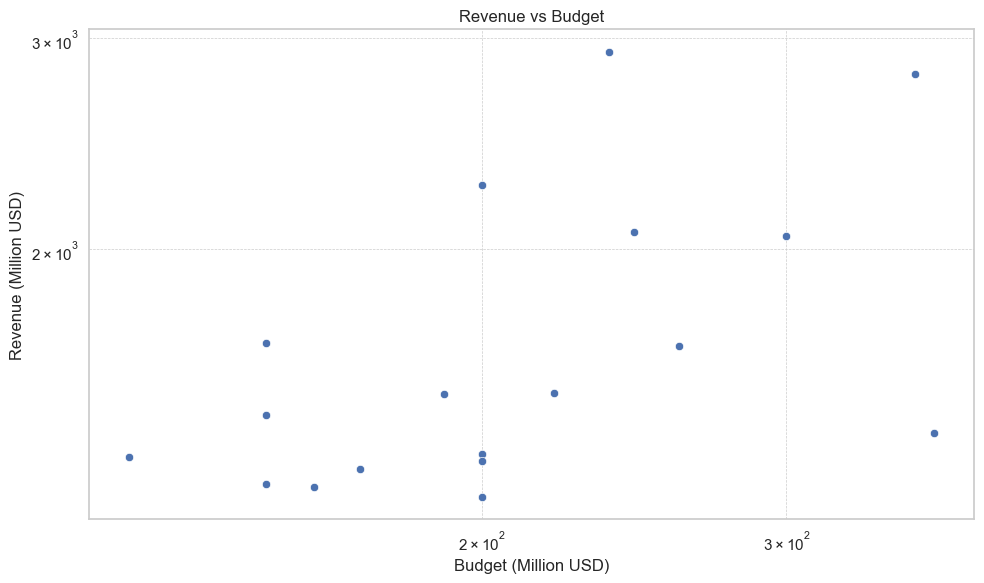

In [74]:

# Add release_year column
df = df.withColumn("release_year", year("release_date"))

# Filter out null values to avoid plotting issues
plot_df = df.select("budget_musd", "revenue_musd") \
            .dropna(subset=["budget_musd", "revenue_musd"]) \
            .toPandas()

# Set plot style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x="budget_musd", y="revenue_musd")
plt.title("Revenue vs Budget")
plt.xlabel("Budget (Million USD)")
plt.ylabel("Revenue (Million USD)")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

##### ROI Distribution by Genre

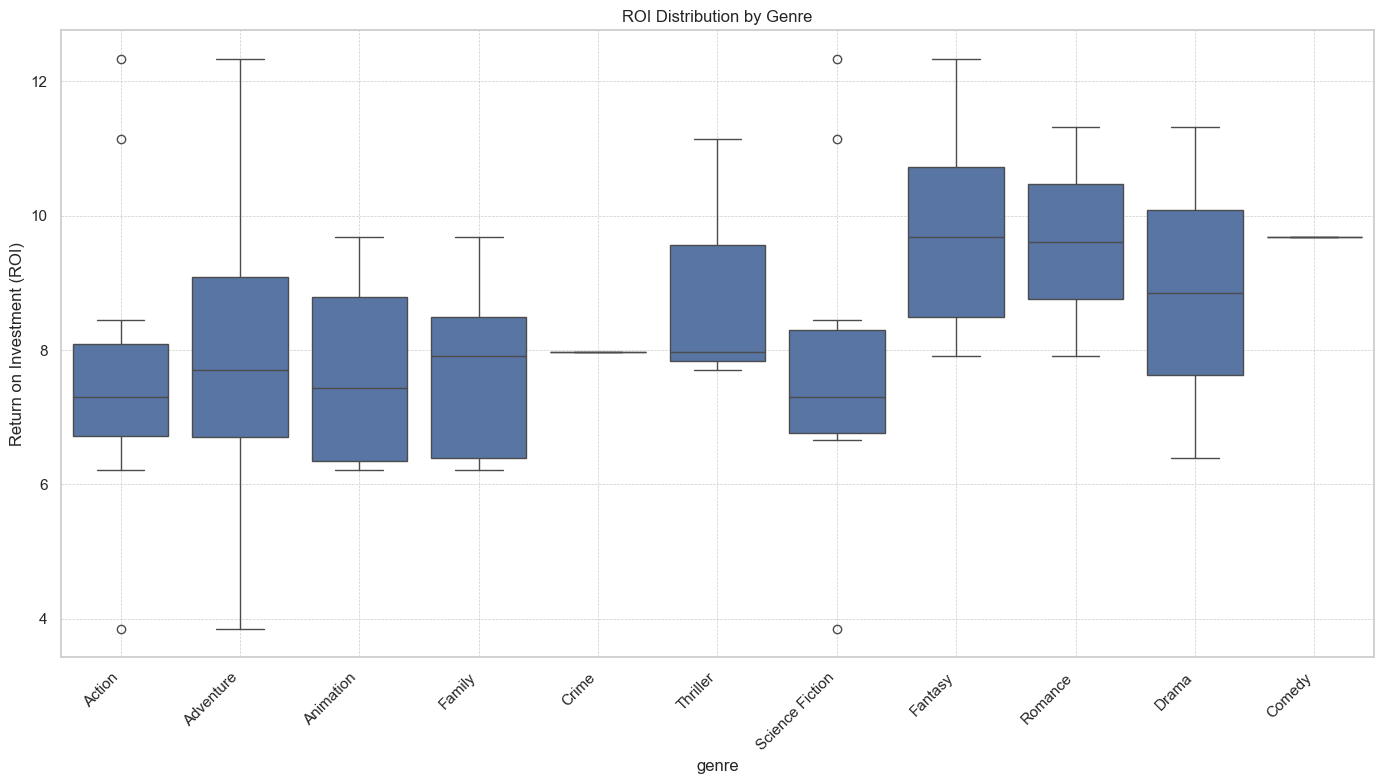

In [75]:
# 1. Drop rows with null genres
df_clean = df.filter(col("genres").isNotNull())

# 2. Split genres into arrays
df_split = df_clean.withColumn("genres", split(col("genres"), "\|"))

# 3. Explode genres into individual rows
df_exploded = df_split.withColumn("genre", explode(col("genres")))

# Now you have: title | year | roi | genres (as original array) | genre (single string)

# 4. Collect data back to driver for plotting (Spark can't plot)
pandas_df = df_exploded.select("genre", "roi").toPandas()

# 5. Plotting
plt.figure(figsize=(14, 8))
sns.boxplot(data=pandas_df, x='genre', y='roi')
plt.title('ROI Distribution by Genre')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Return on Investment (ROI)')
plt.grid(True, ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

##### Popularity vs. Rating

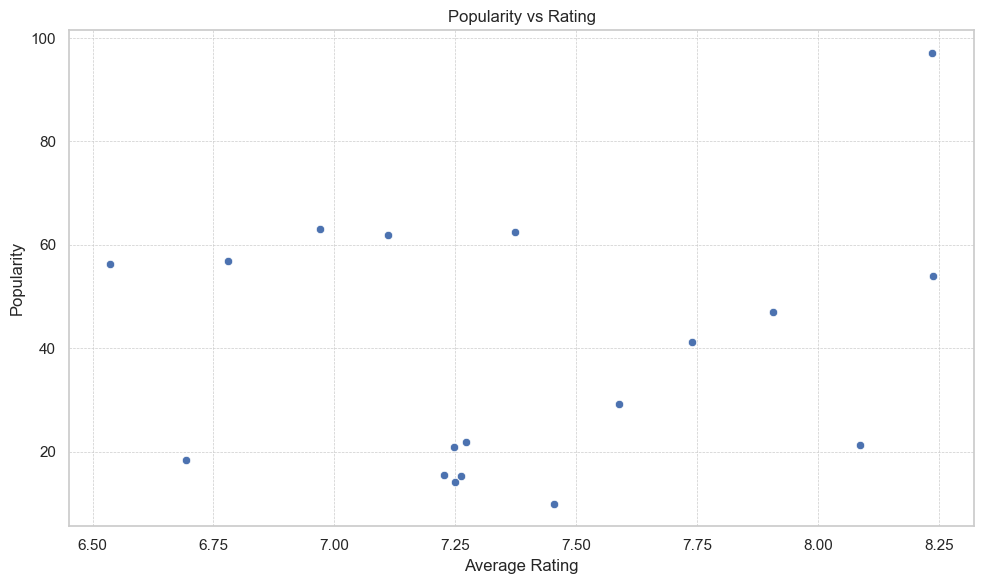

In [76]:
# 1. Filter out rows with nulls in relevant columns
df_clean = df.filter(col("vote_average").isNotNull() & col("popularity").isNotNull())

# 2. Collect small subset (or all if manageable) to pandas
pandas_df = df_clean.select("vote_average", "popularity").toPandas()

# 3. Plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x='vote_average', y='popularity')
plt.title('Popularity vs Rating')
plt.xlabel('Average Rating')
plt.ylabel('Popularity')
plt.grid(True, ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

##### Yearly Trends in Box Office Performance

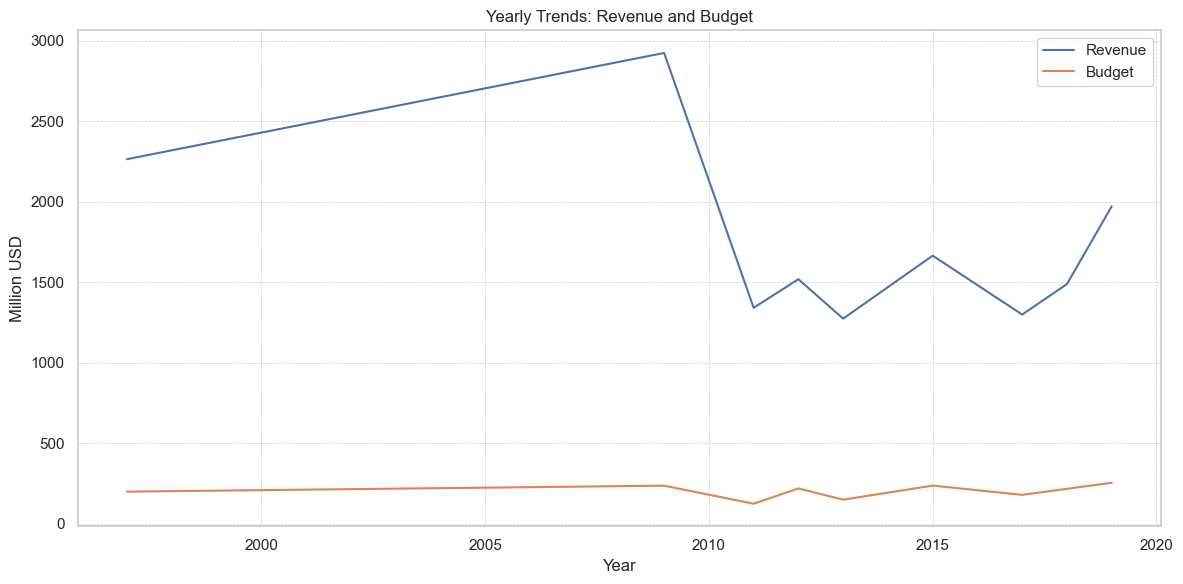

In [77]:
# 1. Group by release_year and compute mean
yearly_revenue = df.groupBy("release_year").agg(
    mean("revenue_musd").alias("revenue_musd"),
    mean("budget_musd").alias("budget_musd"),
    mean("popularity").alias("popularity")
)

# 2. Drop nulls in any of the important columns
yearly_revenue_clean = yearly_revenue.dropna(subset=["revenue_musd", "budget_musd"])

# 3. Collect to pandas for plotting
pandas_df = yearly_revenue_clean.orderBy("release_year").toPandas()
pandas_df.set_index("release_year", inplace=True)

# 4. Plot with seaborn/matplotlib
plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_df, x=pandas_df.index, y="revenue_musd", label="Revenue")
sns.lineplot(data=pandas_df, x=pandas_df.index, y="budget_musd", label="Budget")
plt.title("Yearly Trends: Revenue and Budget")
plt.xlabel("Year")
plt.ylabel("Million USD")
plt.legend()
plt.grid(True, ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

##### Comparison of Franchise vs. Standalone Success

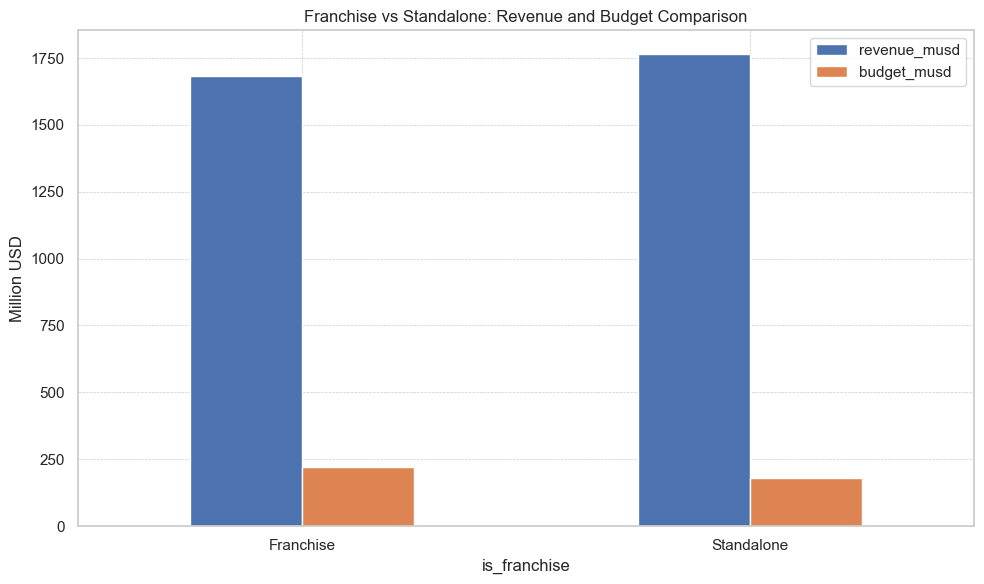

In [78]:
# 1. Create 'is_franchise' column
df = df.withColumn("is_franchise", col("belongs_to_collection").isNotNull())

# 2. Group by 'is_franchise' and compute means
franchise_vs_standalone = df.groupBy("is_franchise").agg(
    mean("revenue_musd").alias("revenue_musd"),
    mean("budget_musd").alias("budget_musd"),
    mean("popularity").alias("popularity"),
    mean("vote_average").alias("vote_average")
)

# 3. Convert to pandas for plotting
pdf = franchise_vs_standalone.toPandas()

# 4. Replace True/False with readable labels
pdf["is_franchise"] = pdf["is_franchise"].map({True: "Franchise", False: "Standalone"})
pdf.set_index("is_franchise", inplace=True)

# 5. Plot bar chart
pdf[["revenue_musd", "budget_musd"]].plot(kind="bar", figsize=(10, 6))
plt.title("Franchise vs Standalone: Revenue and Budget Comparison")
plt.ylabel("Million USD")
plt.xticks(rotation=0)
plt.grid(True, ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()